### Quantifying and Visualizing Distribution Shift in Augmented Test Sets
Now that we have generated perturbed variants of the test set, we would like to investigate how the noise affects the distribution of the data. 

#### 1. Quantifying Distribution Shift
- Extract relevant features from both the original and noisy datasets. These features might include word frequencies, sentence lengths, POS tag distributions, etc., depending on what aspects of the data the noise might affect.

#### 2. Visualizing Distribution Shift
a) Histograms:
- Plot histograms for features like sentence length, word frequency, etc., for both datasets. Overlaying these histograms can provide a visual comparison.

b) Box Plots:
- Box plots are useful for visualizing the distribution of numerical features (e.g., sentence length).

c) Word Clouds:
- Generate word clouds for the original and noisy datasets to visually compare the most frequent words.

d) POS Tag Distribution:
- If you have POS tag features, visualize their distribution in both datasets using bar plots.

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
import re
from tqdm import tqdm
from typing import Dict

### Load data and generate features

In [17]:
def load_datasets(input_dir):
    datasets = {}
    for file in os.listdir(input_dir):
        if file.endswith(".csv"):
            noise_levels = re.findall(r'_(psr|ppr|pri|prs|prd)(\d{3})', file)
            noise_dict = {typ: int(level) / 100 for typ, level in noise_levels}

            df = pd.read_csv(os.path.join(input_dir, file), sep='\t')
            datasets[file] = {'data': df, 'noises': noise_dict}

    return datasets

datasets = load_datasets('/Users/johann/Documents/Uni/real-time-uncertainty-text-classification/data/robustness-study/preprocessed_noisy')


In [18]:
# features
def calculate_word_frequencies(df):
    word_freq = {}
    for text in df['text']:
        words = text.split()
        for word in words:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    return word_freq

def calculate_sentence_lengths(df):
    sentence_lengths = df['text'].apply(lambda x: len(x.split()))
    return sentence_lengths

def calculate_pos_distributions(df):
    pos_counts = Counter()
    for text in df['text']:
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        pos_counts.update([tag for _, tag in tags])
    return pos_counts


In [23]:
# compute features for each dataset
# use tqdm to show progress bar

for filename, content in tqdm(datasets.items(), desc='Calculating features'):
    df = content['data']

    word_frequencies = calculate_word_frequencies(df)
    sentence_lengths = calculate_sentence_lengths(df)
    pos_distributions = calculate_pos_distributions(df)

    datasets[filename]['word_freq'] = word_frequencies
    datasets[filename]['sentence_lengths'] = sentence_lengths
    datasets[filename]['pos_distributions'] = pos_distributions


Calculating features: 100%|██████████| 51/51 [01:30<00:00,  1.76s/it]


### Visualize distribution shift

#### Sentence Lengths

In [37]:
def get_average_sentence_lengths(datasets: Dict, noise_type=None):
    """
    Get average sentence lengths for all datasets / noise types or for a specific noise type.
    :param datasets: 
    :param noise_type: 
    :return: avg_sentence_lengths
    """
    avg_sentence_lengths = {}

    if noise_type is None:
        # get average sentence length for all datasets / noise types
        for filename, data in datasets.items():
            for noise_type, noise_level in data['noises'].items():
                if noise_type not in avg_sentence_lengths:
                    avg_sentence_lengths[noise_type] = {}
                avg_sentence_lengths[noise_type][noise_level] = data['sentence_lengths'].mean()
            noise_type = list(data['noises'].keys())[0]
            noise_level = data['noises'][noise_type]
            avg_sentence_length = data['sentence_lengths'].mean()
            avg_sentence_lengths[noise_type][noise_level] = avg_sentence_length

    else:
        # get average sentence length for a specific noise type
        for filename, data in datasets.items():
            if noise_type in data['noises']:
                noise_level = data['noises'][noise_type]
                avg_sentence_length = data['sentence_lengths'].mean()
                avg_sentence_lengths[noise_level] = avg_sentence_length
    
    return avg_sentence_lengths

In [38]:
avg_sentence_lengths = get_average_sentence_lengths(datasets)

In [48]:
def plot_sentence_length_distribution(avg_sentence_lengths):
    """
    Plot sentence length distribution for all datasets / noise types or for a specific noise type.
    :param avg_sentence_lengths: 
    :return: 
    """
    plt.figure(figsize=(10, 10))
    plt.ylim(0,18)
    plt.xlabel('Noise Level')
    plt.ylabel('Average Sentence Length (Tokens)')
    plt.title(f'Average Sequence Length per Noise Level')
    
    for noise_type, noise_levels in avg_sentence_lengths.items():
        plt.scatter(list(noise_levels.keys()), list(noise_levels.values()), label=noise_type)
    
    plt.legend()

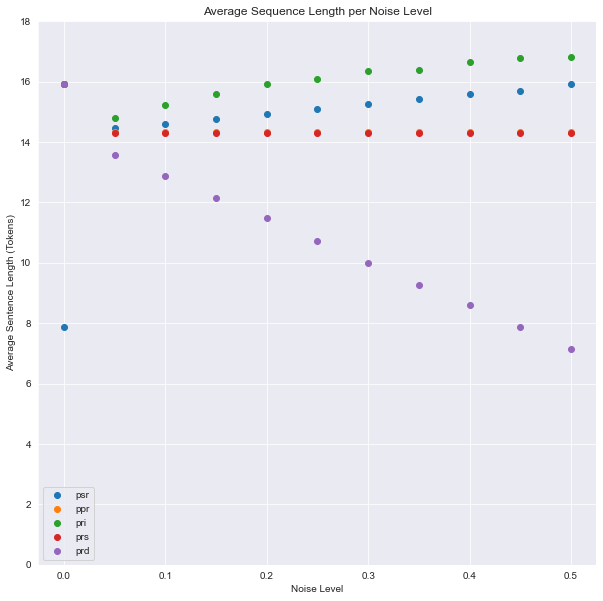

In [49]:
plot_sentence_length_distribution(avg_sentence_lengths)
# shouldn't the average sentence length be the same for all noise types for noise level = 0?

**Investigate why the average sentence length is not the same for all noise types for noise level = 0.**

#### Word Frequencies

In [52]:
def get_word_frequencies(datasets: Dict, noise_type=None):
    """
    Get word frequencies for all datasets / noise types or for a specific noise type.
    :param datasets: 
    :param noise_type: 
    :return: word_frequencies
    """
    word_frequencies = {}

    if noise_type is None:
        # get word frequencies for all datasets / noise types
        for filename, data in datasets.items():
            for noise_type, noise_level in data['noises'].items():
                if noise_type not in word_frequencies:
                    word_frequencies[noise_type] = {}
                word_frequencies[noise_type][noise_level] = data['word_freq']
    else:
        # get word frequencies for a specific noise type
        for filename, data in datasets.items():
            if noise_type in data['noises']:
                noise_level = data['noises'][noise_type]
                word_frequencies[noise_level] = data['word_freq']
    
    return word_frequencies

In [53]:
word_frequencies = get_word_frequencies(datasets)

In [76]:
from collections import defaultdict

aggregated_word_freq = defaultdict(int)

for filename, content in datasets.items():
    for word, freq in content['word_freq'].items():
        aggregated_word_freq[word] += freq

sorted_word_freq = sorted(aggregated_word_freq.items(), key=lambda x: x[1], reverse=True)

top_n = 10
top_n_words = sorted_word_freq[:top_n]

In [77]:
top_n_words

[('user', 133376),
 ('a', 66609),
 ('emoji', 58999),
 ('bitch', 57546),
 ('rt', 52636),
 ('i', 51695),
 ('the', 51224),
 ('you', 45127),
 ('to', 36767),
 ('and', 30217)]

#### POS Tag Distributions

In [83]:
from src.experiments.robustness_study.noise import WordDistributionByPOSTag

In [78]:
def get_pos_distributions(datasets: Dict, noise_type=None):
    """
    Get POS tag distributions for all datasets / noise types or for a specific noise type.
    :param datasets: 
    :param noise_type: 
    :return: pos_distributions
    """
    pos_distributions = {}

    if noise_type is None:
        # get POS tag distributions for all datasets / noise types
        for filename, data in datasets.items():
            for noise_type, noise_level in data['noises'].items():
                if noise_type not in pos_distributions:
                    pos_distributions[noise_type] = {}
                pos_distributions[noise_type][noise_level] = data['pos_distributions']
    else:
        # get POS tag distributions for a specific noise type
        for filename, data in datasets.items():
            if noise_type in data['noises']:
                noise_level = data['noises'][noise_type]
                pos_distributions[noise_level] = data['pos_distributions']
    
    return pos_distributions

In [79]:
pos_distributions = get_pos_distributions(datasets)

In [101]:
# pick out noise type, remap pos tags using WordDistributionByPOSTag.nltk_to_wordnet_pos, plot chart for increasing noise level
def plot_pos_distribution(pos_distributions, noise_type='psr'):
    # Assuming pos_distributions is a dict with noise levels as keys
    # and Counter objects with POS tags as values
    plt.figure(figsize=(10, 6))
    
    pos_counts = pos_distributions[noise_type]  
    
    for level, pos_counter in sorted(pos_counts.items()):
        print(level, pos_counter)
        # Select a few top POS tags for clarity in the plot
        top_tags = [tag for tag, count in pos_counter.most_common(5)]
        values = [pos_counter[tag] for tag in top_tags]
        plt.plot(top_tags, values, label=f'Noise Level {level}')
    
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.title('POS Tag Distribution for Noise Type: ' + noise_type)
    plt.legend()
    plt.show()

In [102]:
plot_pos_distribution(pos_distributions)

0.0 {'n': 53, 'a': 43, 'v': 302, 'r': 7, None: 4}


AttributeError: 'dict' object has no attribute 'most_common'

<Figure size 720x432 with 0 Axes>

In [110]:
pos_distributions['psr'][0.1]

Counter({'NN': 17975,
         'VBP': 2877,
         'JJ': 5714,
         'NNS': 2792,
         'RP': 455,
         'TO': 826,
         'VB': 2598,
         'IN': 4107,
         'MD': 335,
         'VBZ': 1201,
         'DT': 3740,
         'VBG': 940,
         'VBD': 1360,
         'RB': 2793,
         'PRP': 2395,
         'VBN': 561,
         'CC': 961,
         'PRP$': 1224,
         'CD': 146,
         "''": 93,
         'WRB': 396,
         'WDT': 158,
         'WP': 237,
         'PDT': 68,
         'RBR': 82,
         'EX': 21,
         'JJR': 98,
         'NNP': 163,
         'FW': 44,
         'JJS': 74,
         'UH': 15,
         'RBS': 14,
         'WP$': 3,
         'NNPS': 1})

### Further Illustration

Pick out a single sequence from unperturbed test set, show how it changes for increasing noise level for each noise type

In [117]:
def get_sequence(datasets: Dict, noise_type, noise_level, index):
    """
    Get a single sequence from a dataset for a specific noise type and noise level.
    :param datasets: 
    :param noise_type: 
    :param noise_level: 
    :param index: 
    :return: sequence
    """
    p_sr = 0.0
    p_pr = 0.0
    p_ri = 0.0
    p_rs = 0.0
    p_rd = 0.0

    if noise_type == 'psr':
        p_sr = noise_level
    elif noise_type == 'ppr':
        p_pr = noise_level
    elif noise_type == 'pri':
        p_ri = noise_level
    elif noise_type == 'prs':
        p_rs = noise_level
    elif noise_type == 'prd':
        p_rd = noise_level
    else:
        raise ValueError(f'Invalid noise type: {noise_type}')
        
    format_params = f"_psr{int(p_sr * 100):03d}_ppr{int(p_pr * 100):03d}_pri{int(p_ri * 100):03d}_prs{int(p_rs * 100):03d}_prd{int(p_rd * 100):03d}"

    sequence = datasets['test' + format_params + '.csv']['data']['text'][index]
    return sequence

In [135]:
example_index = 71
print(get_sequence(datasets, 'psr', 0.0, example_index))
print(get_sequence(datasets, 'psr', 0.5, example_index))
print(get_sequence(datasets, 'ppr', 0.5, example_index))
print(get_sequence(datasets, 'pri', 0.5, example_index))
print(get_sequence(datasets, 'prs', 0.5, example_index))
print(get_sequence(datasets, 'prd', 0.5, example_index))

user wanted me to let everyone know he downloaded the whole acoustic justin bieber album hashtag fag
exploiter need maine to let everyone know he download the entirely acoustical justin bieber album hashtag fag
user goes me to let everyone know he downloaded the whole acoustic justin bieber shit hashtag ass
user wanted me to let everyone know he downloaded the whole acoustic justin bieber album hashtag fag
let bieber whole know hashtag acoustic the he wanted downloaded me to justin everyone album user fag
user wanted to let whole acoustic album fag
